https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

In [ ]:
import pandas as pd

train_data = pd.read_csv("drive/MyDrive/ts_data/sales_train.csv")
test_data = pd.read_csv("drive/MyDrive/ts_data/test.csv")

In [ ]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
train_data.isnull().sum(axis=0)

,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0


In [ ]:
train_data["date_block_num"].max()

33

In [ ]:
train_data["date"].min()

'01.01.2013'

In [ ]:
train: 04.2014 - 11.2014 val: 12/2014
train: 01.2013 - 10.2014 val: 11/2014
train: 01.2013 - 09.2014 val: 10/2014

SyntaxError: invalid syntax (<ipython-input-7-aff888a0f960>, line 1)

In [ ]:
train_data_by_month = train_data.groupby(["date_block_num", "shop_id", "item_id"])["item_cnt_day"].sum().reset_index(name="item_cnt_month")

<Axes: >

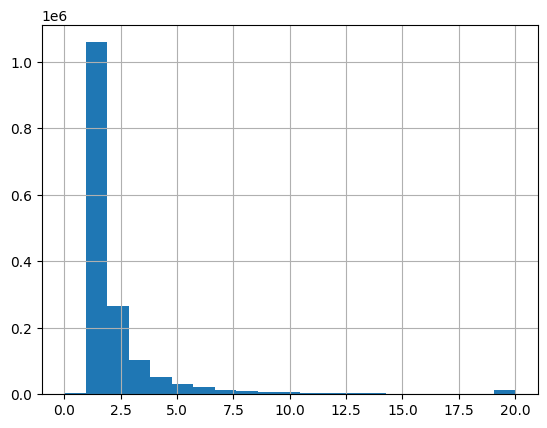

In [ ]:
train_data_by_month["item_cnt_month"].clip(0,20).hist(bins=21)

In [ ]:
train_data_by_month["item_cnt_month"].clip(0,20).value_counts(normalize=True)

,proportion
item_cnt_month,
1.0,0.658013
2.0,0.164998
3.0,0.064151
4.0,0.033140
5.0,0.019870
6.0,0.012883
7.0,0.008738
20.0,0.007763
8.0,0.006482


In [ ]:
train_data_by_month.loc[(train_data_by_month["shop_id"] == 2) & (train_data_by_month["item_id"] == 486)]

,date_block_num,shop_id,item_id,item_cnt_month
1067225,20,2,486,1.0
1107647,21,2,486,1.0
1150239,22,2,486,2.0
1302051,25,2,486,3.0
1343436,26,2,486,2.0
1383900,27,2,486,1.0
1448993,29,2,486,2.0
1547916,32,2,486,1.0
1577594,33,2,486,3.0


In [ ]:
train_data_by_month_sample = train_data_by_month.loc[train_data_by_month["date_block_num"] > 20]

In [ ]:
train_data_by_month_sample

,date_block_num,shop_id,item_id,item_cnt_month
1107644,21,2,32,2.0
1107645,21,2,464,1.0
1107646,21,2,482,1.0
1107647,21,2,486,1.0
1107648,21,2,491,1.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [ ]:
from itertools import product

dates_unique = train_data_by_month_sample["date_block_num"].unique()
shops_unique = train_data_by_month_sample["shop_id"].unique()
items_unique = train_data_by_month_sample["item_id"].unique()

date_shop_item_grid = pd.DataFrame([(date, shop, item) for date, shop, item in product(dates_unique, shops_unique, items_unique)])

In [ ]:
date_shop_item_grid.columns = ["date_block_num", "shop_id", "item_id"]

In [ ]:
date_shop_item_grid = date_shop_item_grid.merge(train_data_by_month_sample, on=["date_block_num", "shop_id", "item_id"], how="left").fillna(0)

In [ ]:
date_shop_item_grid.loc[(date_shop_item_grid["shop_id"] == 2) & (date_shop_item_grid["item_id"] == 486)]

,date_block_num,shop_id,item_id,item_cnt_month
3,21,2,486,1.0
680727,22,2,486,2.0
1361451,23,2,486,0.0
2042175,24,2,486,0.0
2722899,25,2,486,3.0
3403623,26,2,486,2.0
4084347,27,2,486,1.0
4765071,28,2,486,0.0
5445795,29,2,486,2.0
6126519,30,2,486,0.0


In [ ]:
def predict_const(val_data: pd.DataFrame) -> pd.Series:
    return [0] * len(val_data)

In [ ]:
def predict_as_previous_month(train_data, val_data):
    last_month = train_data.loc[train_data["date_block_num"] == train_data["date_block_num"].max()]
    last_month.rename(columns={"item_cnt_month": "prediction"}, inplace=True)
    last_month["date_block_num"] += 1
    val_data = val_data.merge(last_month, on=["date_block_num", "shop_id", "item_id"], how="left")
    return val_data

In [ ]:
def predict_as_sliding_window(train_data, val_data, window: int = 3, agg_func: str = "mean"):
    period_train_data = train_data.loc[train_data["date_block_num"] > train_data["date_block_num"].max() - window]
    period_train_data = period_train_data.groupby(["shop_id", "item_id"])["item_cnt_month"].agg(agg_func).reset_index(name="prediction")
    val_data = val_data.merge(period_train_data, on=["shop_id", "item_id"], how="left")
    return val_data

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from sklearn.metrics import mean_squared_error

validation_folds = [
    (range(26, 29), [29]),
    (range(26, 30), [30]),
    (range(26, 31), [31]),
    (range(26, 32), [32]),
    (range(26, 33), [33]),
]

for train_date_block_nums, val_date_block_nums in validation_folds:
    train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(train_date_block_nums)]
    val_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(val_date_block_nums)]
    val_fold = predict_as_sliding_window(train_fold, val_fold, window=3, agg_func="median")
    metrics = mean_squared_error(val_fold["item_cnt_month"].clip(0,20), val_fold["prediction"].clip(0,20), squared=False)

    print(f"{val_date_block_nums}: {metrics: .2f}")

[29]:  0.57
[30]:  0.51
[31]:  0.53
[32]:  0.62
[33]:  0.64


In [ ]:
last_month = train_fold.loc[train_fold["date_block_num"] == train_fold["date_block_num"].max()]
last_month.rename(columns={"item_cnt_month": "prediction"}, inplace=True)
val_fold = val_fold.merge(last_month, on=["date_block_num", "shop_id", "item_id"], how="left")

In [ ]:
date_shop_item_grid

,date_block_num,shop_id,item_id,item_cnt_month
0,21,2,32,2.0
1,21,2,464,1.0
2,21,2,482,1.0
3,21,2,486,1.0
4,21,2,491,1.0
...,...,...,...,...
8849407,33,36,13092,0.0
8849408,33,36,16797,0.0
8849409,33,36,18060,0.0
8849410,33,36,10803,0.0


In [ ]:
CONST 0
[29]:  0.73
[30]:  0.69
[31]:  0.72
[32]:  0.78
[33]:  0.80

Previous month
[29]:  0.66
[30]:  0.61
[31]:  0.64
[32]:  0.71
[33]:  0.82

Mean last 3 months
[29]:  0.65
[30]:  0.62
[31]:  0.63
[32]:  0.70
[33]:  0.74

Median last 3 months
[29]:  0.66
[30]:  0.60
[31]:  0.61
[32]:  0.72
[33]:  0.75

,date_block_num,shop_id,item_id,item_cnt_month
0,26,2,32,1.0
1,26,2,482,1.0
2,26,2,486,2.0
3,26,2,787,1.0
4,26,2,1108,2.0


In [ ]:
def create_lag_features(target_data, all_data, lags_range, months_ahead):
    new_data = pd.DataFrame([])
    for month_ahead in range(months_ahead):
        month_ahead_data = target_data.copy()
        for lag in lags_range:
            all_data_copy = all_data.copy()
            all_data_copy["date_block_num"] += lag + month_ahead
            all_data_copy.rename(columns={"item_cnt_month": f"item_cnt_month_lag_{lag}"}, inplace=True)
            month_ahead_data = month_ahead_data.merge(all_data_copy, on=["shop_id", "item_id", "date_block_num"], how="left").fillna(0)
        month_ahead_data["month_ahead"] = month_ahead + 1
        new_data = pd.concat([new_data, month_ahead_data])
    return new_data

In [ ]:
import lightgbm as lgb

parameters = {
    #default
    "objective": "regression_l2",
    "learning_rate": 0.1,
    "metric": "rmse",
    "seed": 42,

    #regularization
    "max_leaves": 32,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "min_data_in_leaf": 15
}



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from copy import deepcopy

n_rounds = 150

lags_range = [1, 2, 3]
metrics_storage = []

for train_date_block_nums, val_date_block_nums in validation_folds:
    train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(train_date_block_nums)]
    val_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(val_date_block_nums)]

    train_fold = create_lag_features(train_fold, date_shop_item_grid, lags_range, 1)
    val_fold = create_lag_features(val_fold, date_shop_item_grid, lags_range, 1)

    lgb_train = lgb.Dataset(train_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=train_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
    lgb_val = lgb.Dataset(val_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=val_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
    results = {}
    model_fold = lgb.train(parameters, lgb_train, n_rounds, valid_sets=(lgb_val, lgb_train), valid_names=("val", "train"), callbacks=[lgb.log_evaluation(period=1), lgb.record_evaluation(results)])
    metrics_storage.append(deepcopy(results))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 2042172, number of used features: 3
[LightGBM] [Info] Start training from score 0.097777
[1]	train's rmse: 0.662837	val's rmse: 0.608444
[2]	train's rmse: 0.649775	val's rmse: 0.597701
[3]	train's rmse: 0.63899	val's rmse: 0.588874
[4]	train's rmse: 0.630055	val's rmse: 0.581388
[5]	train's rmse: 0.622671	val's rmse: 0.575154
[6]	train's rmse: 0.616678	val's rmse: 0.569802
[7]	train's rmse: 0.611733	val's rmse: 0.565388
[8]	train's rmse: 0.600051	val's rmse: 0.552545
[9]	train's rmse: 0.596663	val's rmse: 0.54943
[10]	train's rmse: 0.593887	val's rmse: 0.546842
[11]	train's rmse: 0.591657	val's rmse: 0.54489
[12]	train's rmse: 0.589761	val's rmse: 0.543137
[13]	train's rmse:

In [ ]:
import numpy as np

final_metrics = np.concatenate([np.array(metrics_storage[i]["val"]["rmse"]).reshape(150,1) for i in range(len(validation_folds))], axis=1)

In [ ]:
final_metrics

(150, 5)

In [ ]:
final_metrics = pd.DataFrame(final_metrics, columns=[f"fold_{i}" for i in range(len(validation_folds))])
final_metrics["mean_rmse"] = final_metrics[[f"fold_{i}" for i in range(len(validation_folds))]].mean(axis=1)

In [ ]:
final_metrics.iloc[final_metrics["mean_rmse"].argmin()]

,135
fold_0,0.486026
fold_1,0.441724
fold_2,0.481704
fold_3,0.547907
fold_4,0.591252
mean_rmse,0.509723


In [ ]:
np.concatenate([np.array(metrics_storage[i]["train"]["rmse"]).reshape(150,1) for i in range(len(validation_folds))], axis=1)[135, :]

array([0.54280991, 0.52563352, 0.50882851, 0.50399399, 0.510168  ])

In [ ]:
train_fold = date_shop_item_grid.loc[date_shop_item_grid["date_block_num"].isin(range(26, 34))]
train_fold = create_lag_features(train_fold, date_shop_item_grid, lags_range, 1)

In [ ]:
n_rounds = 135
lgb_train = lgb.Dataset(train_fold[[f"item_cnt_month_lag_{lag}" for lag in lags_range]], label=train_fold["item_cnt_month"].clip(0, 20), free_raw_data=False)
model = lgb.train(parameters, lgb_train, n_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.364081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 5445792, number of used features: 3
[LightGBM] [Info] Start training from score 0.091690


In [ ]:
test_data["date_block_num"] = 34

In [ ]:
test_data = create_lag_features(test_data, date_shop_item_grid, lags_range, 1)

In [ ]:
test_data["prediction"] = model.predict(test_data[[f"item_cnt_month_lag_{lag}" for lag in lags_range]])

In [ ]:
test_data["prediction_int"] = test_data["prediction"].apply(int)

In [ ]:
test_data["prediction_int"].value_counts()

,count
prediction_int,
0,207111
1,4386
2,1316
3,556
4,269
5,131
6,123
7,68
8,66


In [ ]:
test_data[[f"item_cnt_month_lag_{lag}" for lag in lags_range]]

,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0.0,1.0,3.0
1,0.0,0.0,0.0
2,1.0,3.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
214195,1.0,0.0,0.0
214196,0.0,0.0,0.0
214197,0.0,0.0,0.0
214198,0.0,0.0,0.0


In [ ]:
train_fold["item_cnt_month"].clip(0, 20).value_counts()

,count
item_cnt_month,
0.0,5180665
1.0,178975
2.0,44909
3.0,16610
4.0,8108
5.0,4691
6.0,2795
7.0,1836
20.0,1680
